In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
sys.path.append("/Users/ruby/Astro/rlb_LWA")
import dsa2000_sensitivity
import importlib
importlib.reload(dsa2000_sensitivity)
import scipy.integrate

In [2]:
#antlocs_filepath = "/Users/ruby/Astro/20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = 2e9
freq_21cm_hz = c/0.21
#antenna_diameter_m = 5
vis_noise = 1.

In [3]:
antpos = dsa2000_sensitivity.get_antpos()

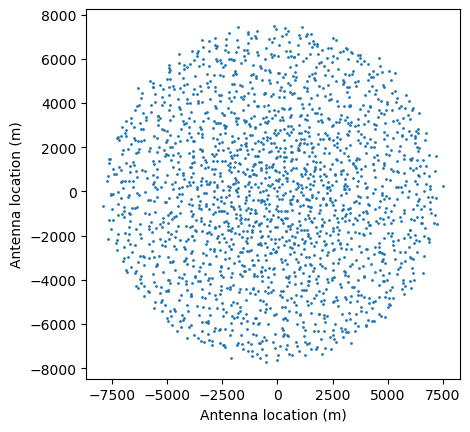

In [4]:
fig, ax = plt.subplots()
ax.scatter(antpos[:,0], antpos[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("Antenna location (m)")
ax.set_ylabel("Antenna location (m)")
plt.show()

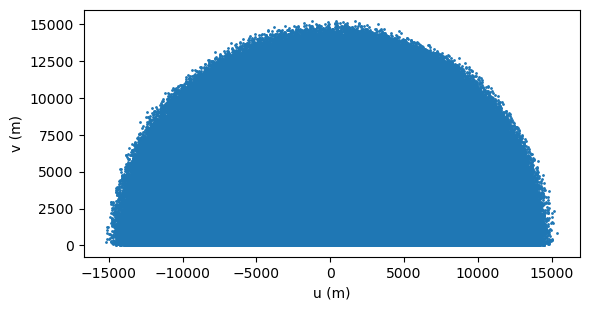

In [5]:
baselines_m = dsa2000_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

In [6]:
uv_plane_variance_arr = np.load("/Users/ruby/Astro/dsa2000_variance.npy")

min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_resolution_hz = 162.5e3
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)

uv_extent = 1000
field_of_view_deg2 = 10.6
field_of_view_diameter = 2 * np.sqrt(field_of_view_deg2 / np.pi)
uv_spacing = 0.5 * 180 / field_of_view_diameter  # Nyquist sample the FoV
u_coords = np.arange(0, uv_extent, uv_spacing)
u_coords = np.append(-np.flip(u_coords[1:]), u_coords)
v_coords = np.copy(u_coords)

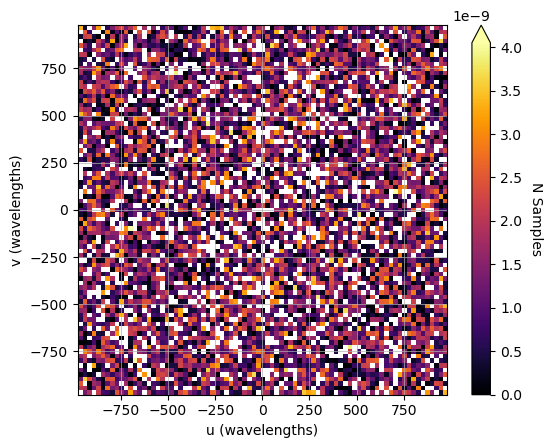

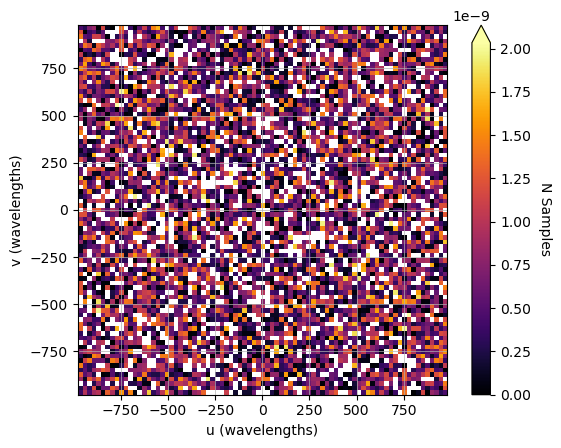

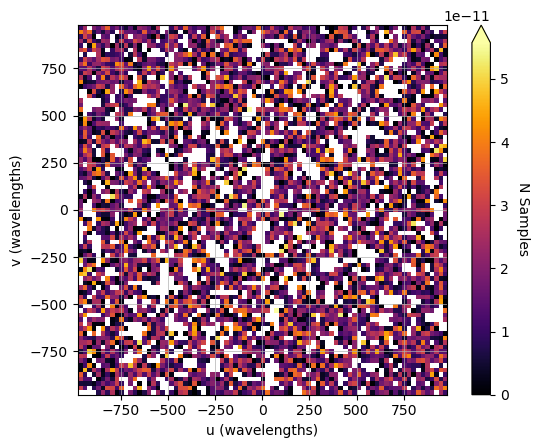

In [7]:
for freq_ind in [0,500,-1]:
    fig, ax = plt.subplots()
    use_cmap = cm.get_cmap("inferno").copy()
    cax = ax.imshow(
        uv_plane_variance_arr[:,:,freq_ind],
        origin="lower",
        interpolation="none",
        extent=[np.min(u_coords), np.max(u_coords), np.min(v_coords), np.max(v_coords)],
        vmin=0,
        cmap=use_cmap,
    )
    ax.set_xlabel("u (wavelengths)")
    ax.set_ylabel("v (wavelengths)")
    ax.grid(linewidth=.5)
    cbar = fig.colorbar(cax, extend="max")
    cbar.set_label("N Samples", rotation=270, labelpad=15)
    plt.show()

In [8]:
field_of_view_deg2 = 10.6
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
antenna_diameter_m = 5
#freq_resolution_hz = 162.5e3
freq_resolution_hz = 0.05e9
uv_extent = 1000
int_time_s = 1
aperture_efficiency = 0.62
tsys_k = 25
u_coords_wl, v_coords_wl, freq_array_hz, uvf_variance_unnorm = dsa2000_sensitivity.generate_uvf_variance(
    save_filepath=None,
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    uv_extent=uv_extent,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    int_time_s=int_time_s
)

On frequency channel 1 of 15
0.03771940718438598
On frequency channel 2 of 15


/Users/ruby/Astro/rlb_LWA/dsa2000_sensitivity.py:180: RuntimeWarning: invalid value encountered in true_divide
  visibility_stddev_mk**2.0 * weights_squared_mat / weights_mat**2.0


0.03285779470284291
On frequency channel 3 of 15
0.02887892112554552
On frequency channel 4 of 15
0.025581328055846557
On frequency channel 5 of 15
0.02281791298808535
On frequency channel 6 of 15
0.020479234925594607
On frequency channel 7 of 15
0.018482509520349133
On frequency channel 8 of 15
0.016764180970838215
On frequency channel 9 of 15
0.015274801256486883
On frequency channel 10 of 15
0.013975432529564562
On frequency channel 11 of 15
0.01283507605579801
On frequency channel 12 of 15
0.011828806093023446
On frequency channel 13 of 15
0.010936396165887064
On frequency channel 14 of 15
0.010141294661371265
On frequency channel 15 of 15
0.009429851796096496


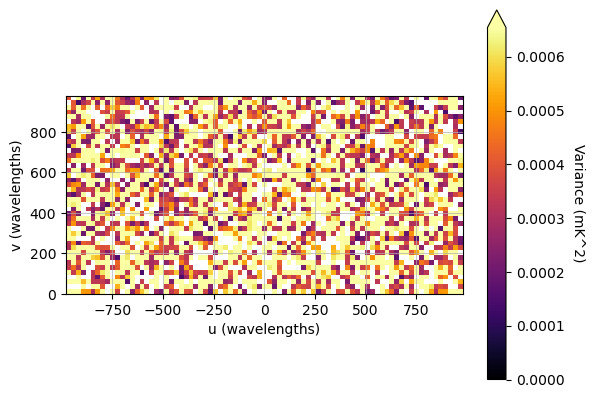

In [9]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    uvf_variance_unnorm[:,:,3].T,
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords_wl), np.max(u_coords_wl), np.min(v_coords_wl), np.max(v_coords_wl)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Variance (mK^2)", rotation=270, labelpad=15)
plt.show()

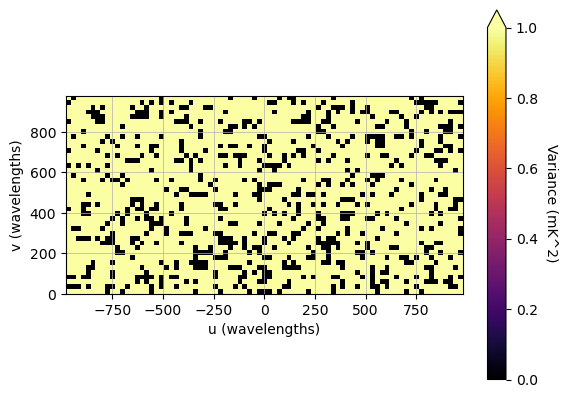

In [10]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    np.isfinite(uvf_variance_unnorm[:,:,3].T),
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords_wl), np.max(u_coords_wl), np.min(v_coords_wl), np.max(v_coords_wl)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Variance (mK^2)", rotation=270, labelpad=15)
plt.show()

In [11]:
delay_array_s, uvn_variance = dsa2000_sensitivity.generate_uvn_variance_simple_ft(freq_array_hz, freq_resolution_hz, uvf_variance_unnorm)

/Users/ruby/Astro/rlb_LWA/dsa2000_sensitivity.py:205: RuntimeWarning: All-NaN slice encountered
  uvn_variance[np.where(~np.isfinite(np.nanmax(uvf_variance, axis=2)))] = np.nan


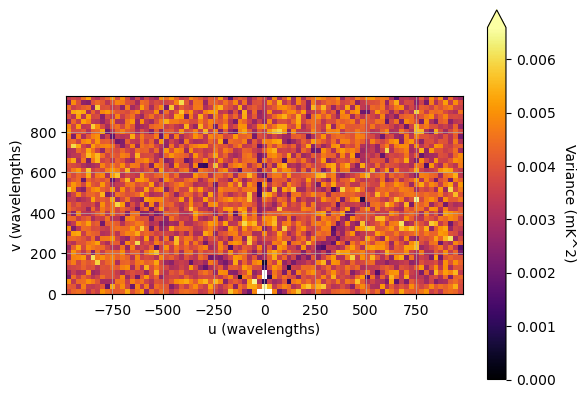

In [12]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    uvn_variance[:,:,0].T,
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords_wl), np.max(u_coords_wl), np.min(v_coords_wl), np.max(v_coords_wl)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Variance (mK^2)", rotation=270, labelpad=15)
plt.show()

In [15]:
uvn_variance_masked = dsa2000_sensitivity.mask_foregrounds(
    delay_array_s,
    uvn_variance,
    max_delay=2e-9,
)

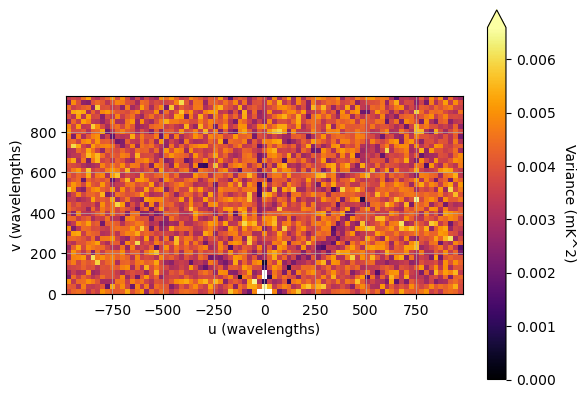

In [16]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    uvn_variance_masked[:,:,0].T,
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords_wl), np.max(u_coords_wl), np.min(v_coords_wl), np.max(v_coords_wl)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Variance (mK^2)", rotation=270, labelpad=15)
plt.show()

In [17]:
kx, ky, kz = dsa2000_sensitivity.uvf_to_cosmology_axis_transform(
    u_coords_wl,
    v_coords_wl,
    freq_array_hz,
    freq_resolution_hz,
)

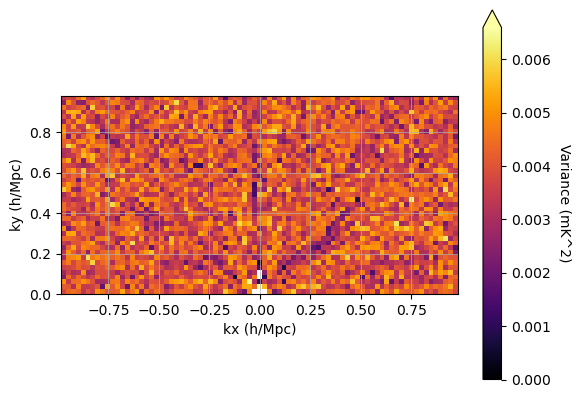

In [18]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    uvn_variance_masked[:,:,0].T,
    origin="lower",
    interpolation="none",
    extent=[np.min(kx), np.max(kx), np.min(ky), np.max(ky)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("kx (h/Mpc)")
ax.set_ylabel("ky (h/Mpc)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Variance (mK^2)", rotation=270, labelpad=15)
plt.show()

In [19]:
bin_centers, binned_ps_variance = dsa2000_sensitivity.get_binned_kcube_variance(
    kx,
    ky,
    kz,
    uvn_variance_masked,
    min_k=None,
    max_k=None,
    n_kbins=10,
)

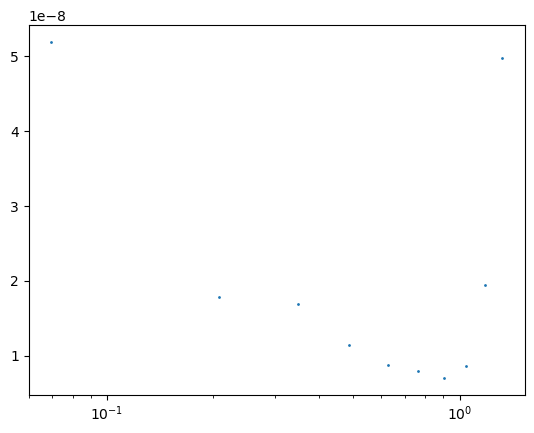

In [20]:
plt.scatter(bin_centers, binned_ps_variance, s=1)
plt.xscale("log")

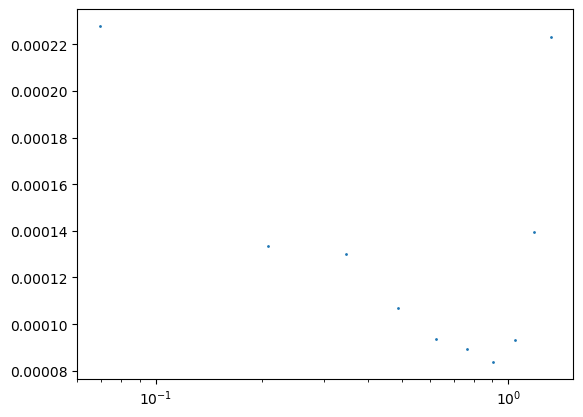

In [21]:
plt.scatter(bin_centers, np.sqrt(binned_ps_variance), s=1)
plt.xscale("log")

In [22]:
visibility_stddev = dsa2000_sensitivity.get_visibility_stddev(
    freq_hz=freq_21cm_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
)

In [23]:
f = open("/Users/ruby/Downloads/camb_61237059_matterpower_z0.67.dat", "r")
file_data = f.readlines()
f.close()

In [24]:
file_data[0].split()[1]

'0.29541E+03'

In [25]:
k = []
power = []
for line in file_data:
    k.append(float(line.split()[0]))
    power.append(float(line.split()[1]))

(0.01, 1.0)

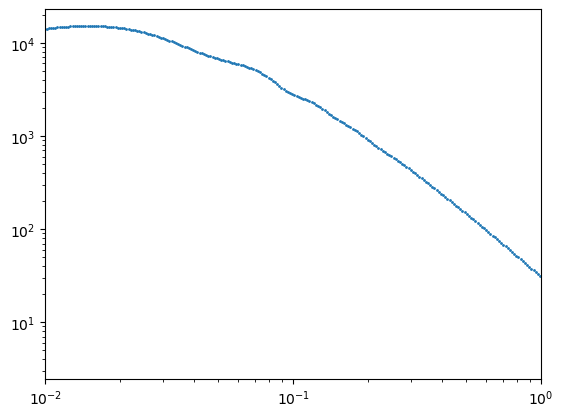

In [27]:
plt.scatter(k, power, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e-2,1e0])

In [28]:
power_new = dsa2000_sensitivity.matter_ps_to_21cm_ps_conversion(np.array(k), np.array(power), 0.67)

(1e-05, 0.02)

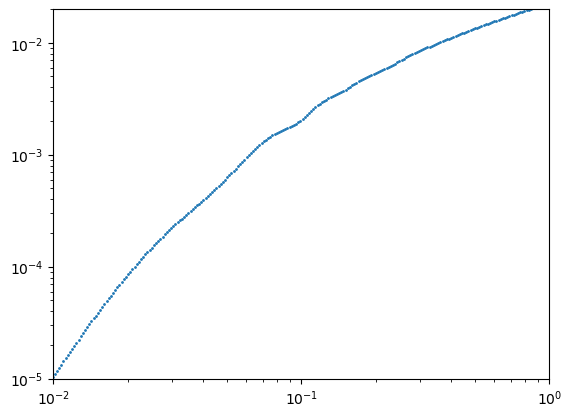

In [29]:
plt.scatter(k, power_new, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e-2,1e0])
plt.ylim(1e-5,2e-2)

In [30]:
200**(-2.5)

1.7677669529663689e-06

In [31]:
1/np.sqrt(1400)

0.026726124191242435